In [9]:
import timeit
import time
from pathlib import Path
import random
import re



import numpy as np
import pandas as pd

from indelsim.classes.sim_config import SimConfiguration
from indelsim.classes.simulation import Simulation


numbers = re.compile(r"\d+\.\d+")


TREES_PATH = Path("../data").resolve() / "chiroptera_data"
TREES_PATH

PosixPath('/home/pupkolab/temp/evo-sim/analysis/data/chiroptera_data')

In [10]:
def refresh_sim(tree_file):
    seed = time.time_ns()%1000000
    random.seed(seed)
    tree_path = Path(tree_file)

    fasta_path = (tree_path.parent / (tree_path.stem + ".fasta")).resolve()
    fasta_text = fasta_path.read_text().replace("-","")
    fasta_seqs = fasta_text.split(">")[1:]
    sequences_length = [len(seq.replace("\n","")) for seq in fasta_seqs]

    min_seq_len = int(min(sequences_length) *0.8)
    max_seq_len = int(max(sequences_length) *1.1)

    ROOT_SEQUENCE_LENGTH = random.randint(min_seq_len, max_seq_len)

    indel_rate = random.uniform(0.0001, 0.05)
    length_param_alpha = random.uniform(1.01, 2.0)
    print("seed=", seed, "indel_rate=",indel_rate, "Root length=", ROOT_SEQUENCE_LENGTH)

    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=length_param_alpha,
                                indel_truncated_length=50,
                                rate_ins=indel_rate, rate_del=indel_rate,
                                deletion_extra_edge_length=50,
                                seed=seed)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)
    return sim

In [11]:
def run_simulation(sim: Simulation, type: str):
    if type == "list":
        sim.msa_from_blocklist()
    if type == "tree":
        sim.msa_from_blocktree()
    if type == "naive":
        sim.msa_from_naive()
    
    sim.msa.compute_msa()

In [12]:
time_log = {"blocklist": [],
            "naive": [],
            "dataset": [],
            "total_branches": [],
            "average_root": []
            }

for tree in TREES_PATH.iterdir():
    if tree.suffix == ".fasta":
        continue
    print(tree.stem)
    times_of_list, times_of_naive = [], []
    root_lengths = []
    for _ in range(5):
        current_sim = refresh_sim(str(tree))
        root_lengths.append(current_sim.sim_nodes[1].length_of_sequence_before)

        blocklist_time = timeit.timeit(lambda: run_simulation(current_sim, "list"), number=1)
        times_of_list.append(blocklist_time)
        print("Blocklist time","is", blocklist_time, "sec")
        
        naive_time = timeit.timeit(lambda: run_simulation(current_sim, "naive"), number=1)
        print("Naive_time","is", naive_time, "sec")
        times_of_naive.append(naive_time)
    time_log["blocklist"].append(np.mean(times_of_list))
    time_log["naive"].append(np.mean(times_of_naive))
    time_log["dataset"].append(tree.stem)

    tree_text = tree.read_text()
    sum_of_branches = sum(map(float, numbers.findall(tree_text)))
    time_log["total_branches"].append(sum_of_branches)
    time_log["average_root"].append(np.mean(root_lengths))


91752_NT_AL_AA
seed= 629425 indel_rate= 0.03965070351479508 Root length= 1142
Blocklist time is 0.021774507000372978 sec
Naive_time is 0.16940510400036146 sec
seed= 138144 indel_rate= 0.004725533722417547 Root length= 1086
Blocklist time is 0.01239569900008064 sec
Naive_time is 0.12417206899954181 sec
seed= 113487 indel_rate= 0.039259267391474 Root length= 815
Blocklist time is 0.010538309000367008 sec
Naive_time is 0.07390743899941299 sec
seed= 917857 indel_rate= 0.017446878530428877 Root length= 1032
Blocklist time is 0.013620816000184277 sec
Naive_time is 0.1056791949995386 sec
seed= 721405 indel_rate= 0.042834617259428075 Root length= 1071
Blocklist time is 0.0098096430001533 sec
Naive_time is 0.12251441999978852 sec
84886_NT_AL_AA
seed= 324782 indel_rate= 0.025923389888506627 Root length= 367
Blocklist time is 0.006269655000323837 sec
Naive_time is 0.01957225899968762 sec
seed= 253353 indel_rate= 0.04773384161124922 Root length= 147
Blocklist time is 0.0021544729997913237 sec
Naiv

In [13]:
time_log_df = pd.DataFrame(time_log)

In [14]:
time_log_df["time_ratio"] = (time_log_df["naive"]/ time_log_df["blocklist"] )

In [15]:
time_log_df.to_csv("approximate_bats_runtime.csv", index=False)

<Axes: xlabel='average_root', ylabel='time_ratio'>

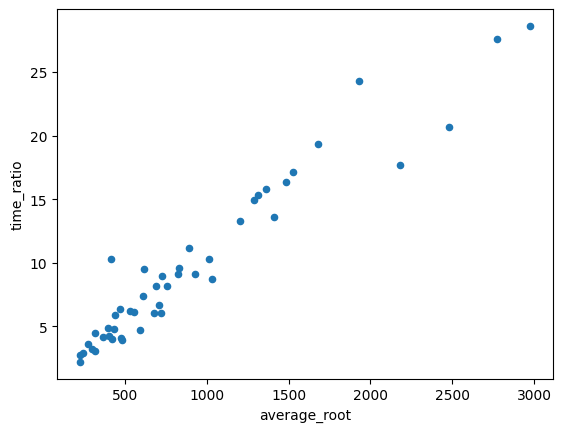

In [16]:
time_log_df.plot(x="average_root", y="time_ratio", kind="scatter")


In [17]:
time_log_bats_df = pd.read_csv("approximate_bats_runtime.csv").sort_values(by="dataset")
time_log_others_df = pd.read_csv("approximate_others_runtime.csv").sort_values(by="dataset")


In [18]:
time_log_bats_df.describe()

,blocklist,naive,total_branches,average_root,time_ratio
count,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.010504,0.148829,1.346505,903.195745,9.692431
std,0.007840,0.218722,0.491523,676.337958,6.632266
min,0.002173,0.005987,0.421907,221.000000,2.203269
25%,0.004958,0.025727,1.013348,424.000000,4.595732
50%,0.008154,0.056647,1.383738,688.600000,8.166430
75%,0.013378,0.181315,1.649370,1246.000000,13.453120
max,0.036236,1.037094,2.512984,2978.600000,28.620301


In [20]:
time_log_others_df.describe()

,blocklist,naive,total_branches,average_root,time_ratio
count,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.096387,2.471288,9.863625,846.778723,17.567258
std,0.066927,3.603085,3.308163,609.060379,13.123839
min,0.023834,0.103556,3.817947,220.000000,4.344946
25%,0.044883,0.433529,7.536847,363.400000,9.440762
50%,0.073668,0.971085,9.917629,719.200000,12.752188
75%,0.127425,2.497643,12.399466,1078.900000,19.601204
max,0.298208,15.650472,20.206212,2737.800000,62.424781


In [19]:
labels = ["bats", "others"]

for label in labels:
    print(f"For {label}:")
    if label == "bats":
        overall_times_df = pd.read_csv("../data/times_bats.csv")
        simulation_times_df = pd.read_csv("../data/empirical_times_bats.csv")
    else:
        overall_times_df = pd.read_csv("../data/times_others.csv")
        simulation_times_df = pd.read_csv("../data/empirical_times_others.csv")

    overall_times_df = overall_times_df.sort_values(by="File_Name")
    simulation_times_df = simulation_times_df.sort_values(by="File_Name")

    print("Overall time", overall_times_df["Duration_Hours"].sum())

    print("Simulation time", simulation_times_df["Duration_Hours"].sum())

    if label == "bats":
        theoretical_simulation_time = (simulation_times_df["Duration_Hours"]*time_log_bats_df["time_ratio"]).sum()
    else:
        theoretical_simulation_time = (simulation_times_df["Duration_Hours"]*time_log_others_df["time_ratio"]).sum()
    print("Apporximate naive time would be", theoretical_simulation_time)

    

For bats:
Overall time 62.27
Simulation time 56.38
Apporximate naive time would be 585.9146844545637
For others:
Overall time 1024.57
Simulation time 699.7500000000001
Apporximate naive time would be 10530.170439734231
